# Nowcasting with Pysteps 

# Importing Libraries

In [3]:
import numpy as np
from pprint import pprint
from pysteps import motion, nowcasts, verification
from pysteps.utils import conversion, transformation
import matplotlib.pyplot as plt
import h5py

Fetching dataset from the local directory

In [4]:
f = h5py.File("D:/Work/Anaconda/envs/pysteps/Lib/site-packages/pysteps/14052019.hdf5", "r")
a_group_key = list(f.keys())[0]
data = f[a_group_key]
data = np.array(data).astype('float')
f.close()

Data corresponds a PPI scan of X-band radar of Peru. It contains reflectivity values(dBZ) of 14/05/2019. 

How you can see, temporal axis corresponds axis 0. This is the standart in Pysteps and Rainymotion.

# Visualising the dataset

In [7]:
from matplotlib import animation
from IPython.display import HTML

ims = []
fig = plt.figure(figsize=(6,6))

for i in range(data.shape[0]):
    im = plt.imshow(data[i, ...], vmax=40, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

# Initialization Phase

In [12]:
metadata = {'institution':'UdeP', 'unit':'dBZ', 'transform':'dB',
            'accutime': 5.0, 'threshold':-31.5, 'zerovalue': -31.5}
n_leadtimes = 8

Pysteps works with a scheme that use metadata for transformation and plotting. For further details see [the reference](https://pysteps.readthedocs.io/en/latest/pysteps_reference/io.html#pysteps-io-importers). Variable **`n_leadtimes`** represents number of time steps. 

Converts data from dbz to rain rate.

In [15]:
R, metadata = conversion.to_rainrate(data, metadata)
R_mini = R[0:7, ...]     # Select the seventh for nowcasting. The rest of data it's for comparison.  
pprint(metadata)



{'accutime': 5.0,
 'institution': 'UdeP',
 'threshold': 0.0003918377307968165,
 'transform': None,
 'unit': 'mm/h',
 'zerovalue': 0.0,
 'zr_a': 200.0,
 'zr_b': 1.6}


Transform to dBR. This is because rainfall rate follow an asimmetry distribution. For Optical Flow methods its better to have a Gaussian(normal) distribution.

In [16]:
dR, metadata = transformation.dB_transform(R_mini, metadata, threshold=0.1, zerovalue=-15.0)
pprint(metadata)

{'accutime': 5.0,
 'institution': 'UdeP',
 'threshold': -10.0,
 'transform': 'dB',
 'unit': 'mm/h',
 'zerovalue': -15.0,
 'zr_a': 200.0,
 'zr_b': 1.6}


# Computational Phase

We use Lucas-Kanade method to find velocity.

In [17]:
oflow_method = motion.get_method("LK")
V = oflow_method(dR[-3:, :, :])

Extrapolate data. 

In [18]:
extrapolate = nowcasts.get_method("extrapolation")
dR[~np.isfinite(dR)] = metadata["zerovalue"]     # Deal with Inf and NaN
R_f = extrapolate(dR[-1, :, :], V, n_leadtimes)

# Output Visualization Phase

Back-transform to rain rate 

In [19]:
R_f, metadata = transformation.dB_transform(R_f, metadata,threshold=-10.0, inverse=True)
R_f[:, np.isnan(R[-1, ...])] = np.nan  # Put NaN values on extrapolated data

In [21]:
fig = plt.figure(figsize=(6,6))
ims = []

# Data
for i in range(R.shape[0]):
    im = plt.imshow(R[i, ...], vmax=2, animated=True)      # Original data
    ims.append([im])

# Nowcasting
for i in range(n_leadtimes):
    im = plt.imshow(R_f[i, ...], vmax=2, animated=True)    # Nowcasting 
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

If we wants, we can return to the original units using data transformations options. 

# Statistics

In [23]:
metadata['unit'] = 'mm/h'
nowcast, metadata = conversion.to_reflectivity(R_f, metadata)
nowcast[nowcast == np.nanmin(nowcast)] = -31.5

Pysteps offers statistics for comparison on this module **`pysteps.verification`**. 

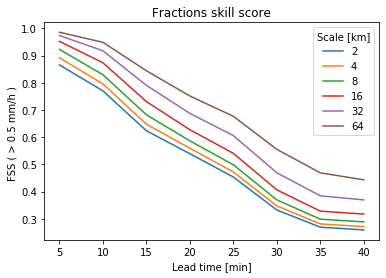

In [22]:
fss = verification.get_method("FSS")
timestep = 5     # Time interval in minutes
scales = [2, 4, 8, 16, 32, 64]     # Scale for comparison
thr = 0.2      # Threshold for the method
score = []
for i in range(n_leadtimes):
    score_ = []
    for scale in scales:
        score_.append(fss(R_f[i, :, :], R[7 + i, :, :], thr, scale))
    score.append(score_)

plt.figure()
x = np.arange(1, n_leadtimes + 1) * timestep
plt.plot(x, score)
plt.legend(scales, title="Scale [km]")
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > 0.5 mm/h ) ")
plt.title("Fractions skill score")
plt.show()